# Example Sequence Prediction With MultiVariable Input

In [1]:
%matplotlib inline

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/home/bhanuchander/aconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### convert series to supervised learning

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Loading Data set

In [4]:
# load dataset
dataset = read_csv('/home/bhanuchander/data/timeseries/pollution.csv', header=0, index_col=0)
dataset.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [5]:
dataset['cbwd'].value_counts()

SE    15290
NW    14150
cv     9387
NE     4997
Name: cbwd, dtype: int64

In [6]:
dataset ['cbwd'] = dataset['cbwd'].astype('category')
dataset ['cbwd'] = dataset[['cbwd']].apply( lambda x: x.cat.codes)

In [7]:
dataset['cbwd'].value_counts()

2    15290
1    14150
3     9387
0     4997
Name: cbwd, dtype: int64

In [8]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler (feature_range=(0, 1))

print values

[[2.0100e+03 1.0000e+00 1.0000e+00 ... 1.7900e+00 0.0000e+00 0.0000e+00]
 [2.0100e+03 1.0000e+00 1.0000e+00 ... 4.9200e+00 0.0000e+00 0.0000e+00]
 [2.0100e+03 1.0000e+00 1.0000e+00 ... 6.7100e+00 0.0000e+00 0.0000e+00]
 ...
 [2.0140e+03 1.2000e+01 3.1000e+01 ... 2.4270e+02 0.0000e+00 0.0000e+00]
 [2.0140e+03 1.2000e+01 3.1000e+01 ... 2.4672e+02 0.0000e+00 0.0000e+00]
 [2.0140e+03 1.2000e+01 3.1000e+01 ... 2.4985e+02 0.0000e+00 0.0000e+00]]


## Fitting Into Scaler : 

In [9]:
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0   0.000000   1.000000   0.279412   
2        0.0        0.0        0.0   0.043478   0.294295   0.279412   
3        0.0        0.0        0.0   0.086957   0.293918   0.279412   
4        0.0        0.0        0.0   0.130435   0.279940   0.279412   
5        0.0        0.0        0.0   0.173913   0.279562   0.294118   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var3(t)   var4(t)  \
1   0.131148   0.545454   0.333333    0.002290    ...         0.0  0.043478   
2   0.114754   0.527273   0.333333    0.007639    ...         0.0  0.086957   
3   0.131148   0.509090   0.333333    0.010698    ...         0.0  0.130435   
4   0.081967   0.509090   0.333333    0.016047    ...         0.0  0.173913   
5   0.114754   0.490910   0.333333    0.021396    ...         0.0  0.217391   

    var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  var11(t)  \
1  0.294295  0.279412  

## Test Train Split

In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print (train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((8760, 1, 16), (8760,), (35063, 1, 16), (35063,))


## Compiling Model

In [11]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 13,451
Trainable params: 13,451
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.compile(loss='mae', optimizer='adam')

## Fitting Model

In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle= False)

## Plot Error / Loss History

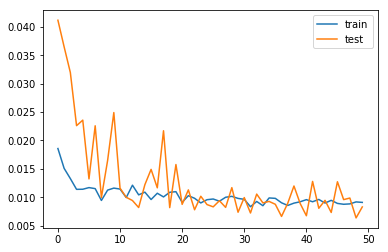

In [14]:
pyplot.plot (history.history['loss'], label='train')
pyplot.plot (history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Error RMSE

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform([inv_yhat])
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform([inv_y])
inv_y = inv_y[:, 0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE in Scaler: %.3f' % rmse)

Test RMSE in Scaler: 0.036


In [16]:
model.compile(loss='mae', optimizer='adam', metrics=["accuracy"])

In [18]:
history = model.fit(train_X, train_y, validation_split=0.33, epochs=50, batch_size=5, verbose=0)

## Model Accuracy

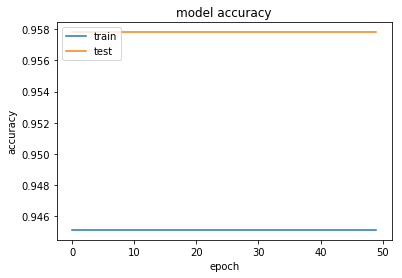

In [19]:
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

## Loss Plot

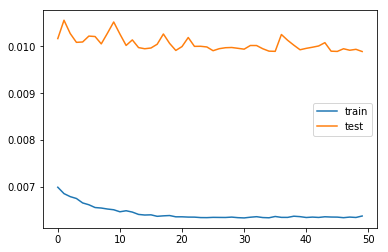

In [20]:
pyplot.plot (history.history['loss'], label='train')
pyplot.plot (history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()